# Load DataSet

In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv('./songs_10000.csv')
df.head()

,Unnamed: 0,artist,seq,song,label,category_Label,language,filtered_seq
0,0,Elijah Blake,no no i aint ever trapped out the bando but lo...,Everyday,0.626,Positive,en,no no i aint ever trap out the bando but lord ...
1,1,Elijah Blake,the drinks down and smoke goes up i feel mysel...,Live Till We Die,0.630,Positive,en,the drink down and smoke go up i feel myself g...
2,2,Elijah Blake,she dont live on planet earth no more she foun...,The Otherside,0.240,Negative,en,she dont live on planet earth no more she foun...
3,3,Elijah Blake,trippin off that grigio mobbin lights low trip...,Pinot,0.536,Positive,en,trippin off that grigio mobbin light low tripp...
4,4,Elijah Blake,i see a midnight panther so gallant and so bra...,Shadows & Diamonds,0.371,Negative,en,i see a midnight panther so gallant and so bra...


In [ ]:
df['category_Label'].value_counts()

,count
category_Label,
Negative,5190
Positive,4698
Neutral,12


In [ ]:
df['filtered_seq'].iloc[0]

'no no i aint ever trap out the bando but lord dont get me wrong i know a couple nigga that do from a place where everybody know your name they say i get ta watch my attitude when they see money man they all start actin strange so fuck with the one that fuck with you they can never say brand new it everyday everyday everyday everyday everyday everyday everyday everyday everyday ive be talkin my shit nigga thats regular ive be lovin em thick life be spectacular i spend like ima die rich nigga flexin everyday thats everyday thats everyday thats everyday thats everyday everyday i see all of these wannabe hot rb singer i swear you all sound the same they start from the bottom so far from the motto you niggasll never be drake shout out to ovo most of them prolly dont know me though i stay in the cut i dont fuck with no body but i d thats a pun on no id when nobody know my name runnin for my dream wasnt hard to do you break bread i swear they all pull out a plate eat with the one who starve 

# Performing Data Augmentation

In [ ]:
!pip install transformers nlpaug torch torchvision nltk
!pip install transformers nlpaug torch torchvision sklearn datasets
from nlpaug.augmenter.word import ContextualWordEmbsAug
from sklearn.model_selection import train_test_split
import torch
import nltk

# Download necessary NLTK resources
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:

# Step 4: Data Augmentation (balance dataset)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Initialize augmenters for Neutral and Positive classes
neutral_augmenter = ContextualWordEmbsAug(model_path='bert-base-uncased', action='insert', device=device, batch_size=64)
positive_augmenter = ContextualWordEmbsAug(model_path='bert-base-uncased', action='insert', device=device, batch_size=64)

# Function for augmentation
def augment_texts(texts, augmenter, target_count):
    augmented_texts = []
    while len(augmented_texts) < target_count:
        batch = texts[:min(len(texts), target_count - len(augmented_texts))]
        augmented_texts.extend(augmenter.augment(batch))
    return augmented_texts[:target_count]

# Split texts by class
negative_texts = df[df['category_Label'] == 'Negative']['filtered_seq'].tolist()
positive_texts = df[df['category_Label'] == 'Positive']['filtered_seq'].tolist()
neutral_texts = df[df['category_Label'] == 'Neutral']['filtered_seq'].tolist()

# Calculate how many new samples are needed
target_size = df['category_Label'].value_counts().max()
positive_needed = target_size - len(positive_texts)
neutral_needed = target_size - len(neutral_texts)

# Augment the data
augmented_positive_texts = augment_texts(positive_texts, positive_augmenter, positive_needed)
augmented_neutral_texts = augment_texts(neutral_texts, neutral_augmenter, neutral_needed)

# Step 5: Combine augmented data with original data
augmented_data = pd.DataFrame({
    'filtered_seq': augmented_positive_texts + augmented_neutral_texts,
    'category_Label': ['Positive'] * len(augmented_positive_texts) + ['Neutral'] * len(augmented_neutral_texts)
})

df_balanced = pd.concat([df, augmented_data], ignore_index=True)


Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
print("\nNew class distribution after augmentation:")
print(df_balanced['category_Label'].value_counts())


New class distribution after augmentation:
category_Label
Positive    5190
Negative    5190
Neutral     5190
Name: count, dtype: int64


print("\nNew class distribution after augmentation:")
print(df_balanced['category_Label'].value_counts())

In [ ]:
df_balanced.to_csv('/content/balanced_songs.csv', index=False)

# Split the Dataset

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Step 1: Prepare the data for splitting
X = df_balanced['filtered_seq']
y = df_balanced['category_Label'].map({'Positive': 1, 'Negative': 0, 'Neutral': 2})  # Encoding

# Initialize StratifiedShuffleSplit for stratified sampling
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# First split: Train+Validation and Test sets
for train_val_idx, test_idx in stratified_split.split(X, y):
    X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
    y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]

# Second split: Train and Validation sets
stratified_split_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in stratified_split_val.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

# Check class distributions
print(f"Train set class distribution:\n{y_train.value_counts()}")
print(f"Validation set class distribution:\n{y_val.value_counts()}")
print(f"Test set class distribution:\n{y_test.value_counts()}")


Train set class distribution:
category_Label
0    3322
2    3321
1    3321
Name: count, dtype: int64
Validation set class distribution:
category_Label
1    831
2    831
0    830
Name: count, dtype: int64
Test set class distribution:
category_Label
2    1038
1    1038
0    1038
Name: count, dtype: int64


# LSTM MODEL

In [ ]:
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from gensim.models import Word2Vec
import numpy as np
from numpy import zeros
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from numpy import zeros
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
lstm_tokenizer = Tokenizer()
lstm_tokenizer.fit_on_texts(X_train)

X_train_lstm = lstm_tokenizer.texts_to_sequences(X_train)
X_val_lstm = lstm_tokenizer.texts_to_sequences(X_val)
X_test_lstm = lstm_tokenizer.texts_to_sequences(X_test)

vocab_length = len(lstm_tokenizer.word_index) + 1

# Step 10: Word2Vec Embedding
model = Word2Vec(sentences=[seq.split() for seq in df_balanced['filtered_seq']], vector_size=100, window=5, min_count=1, workers=4)

# Create a dictionary to hold the embeddings
embeddings_dictionary = {word: model.wv[word] for word in model.wv.index_to_key}

# Create an embedding matrix
embedding_matrix = zeros((vocab_length, 100))

for word, index in lstm_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Step 11: Pad sequences
maxlen = 300
X_train_lstm = pad_sequences(X_train_lstm, padding='post', maxlen=maxlen)
X_val_lstm = pad_sequences(X_val_lstm, padding='post', maxlen=maxlen)

Compling and building the model

In [ ]:
# Step 12: Define and Compile the LSTM Model
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], trainable=False)
lstm_model.add(embedding_layer)
lstm_model.add(Dropout(0.7))
lstm_model.add(Bidirectional(LSTM(80, return_sequences=True)))
lstm_model.add(Bidirectional(LSTM(160)))
lstm_model.add(Dense(3, activation='softmax'))

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 13: Train the LSTM Model
history_lstm = lstm_model.fit(X_train_lstm, y_train,
                         epochs=10,        # Adjust epochs as needed
                         batch_size=32,    # Adjust batch size as needed
                         validation_data=(X_val_lstm, y_val),  # Validation set for tuning
                         verbose=1)        # Verbose output

# Step 14: Model Summary
lstm_model.summary()

# Step 15: Track Training and Validation Accuracy
val_accuracies = []
train_accuracies=[]
train_accuracies = [max(history_lstm.history['accuracy'])]
val_accuracies = [max(history_lstm.history['val_accuracy'])]

print(f"Mean Train Accuracy: {np.mean(train_accuracies)}")
print(f"Mean Validation Accuracy: {np.mean(val_accuracies)}")
best_val_accuracy_model1 = max(val_accuracies)
print("Best Validation Accuracy for Model 1 (Original):", best_val_accuracy_model1)


Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 54ms/step - accuracy: 0.6346 - loss: 0.6594 - val_accuracy: 0.6701 - val_loss: 0.4816
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.7170 - loss: 0.4526 - val_accuracy: 0.7171 - val_loss: 0.4564
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.7365 - loss: 0.4440 - val_accuracy: 0.6027 - val_loss: 0.8279
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7482 - loss: 0.4404 - val_accuracy: 0.7335 - val_loss: 0.4502
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.7483 - loss: 0.4295 - val_accuracy: 0.7372 - val_loss: 0.4449
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.7503 - loss: 0.4311 - val_accuracy: 0.7436 - val_loss: 0.4597
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7563 - loss: 0.4248 - val_accuracy: 0.7155 - val_loss: 0.4920
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.7455 - loss: 0.4442 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 300, 100)            │       2,563,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 300, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 300, 160)            │         115,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 320)                 │         410,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             963 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,146,251 (15.82 MB)

 Trainable params: 527,683 (2.01 MB)

 Non-trainable params: 2,563,200 (9.78 MB)

 Optimizer params: 1,055,368 (4.03 MB)

Mean Train Accuracy: 0.7627458572387695
Mean Validation Accuracy: 0.7435794472694397
Best Validation Accuracy for Model 1 (Original): 0.7435794472694397


Hypertuned LSTM Model

In [ ]:

# Model 2: Hypertuned LSTM Model
model2 = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], trainable=False)
model2.add(embedding_layer)
model2.add(Dropout(0.7))
model2.add(Bidirectional(LSTM(160, return_sequences=True)))  # Changed units
model2.add(Bidirectional(LSTM(250)))  # Changed units
model2.add(Dense(3, activation='softmax'))

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the hypertuned model and store history
history_model2 = model2.fit(X_train_lstm, y_train,
                         epochs=10,        # Adjust epochs as needed
                         batch_size=32,    # Adjust batch size as needed
                         validation_data=(X_val_lstm, y_val),  # Validation set for tuning
                         verbose=1)

# Step 14: Model Summary
model2.summary()

# Step 15: Track Training and Validation Accuracy
val_accuracies = []
train_accuracies=[]
train_accuracies = [max(history_model2.history['accuracy'])]
val_accuracies = [max(history_model2.history['val_accuracy'])]

print(f"Mean Train Accuracy: {np.mean(train_accuracies)}")
print(f"Mean Validation Accuracy: {np.mean(val_accuracies)}")
best_val_accuracy_model2 = max(val_accuracies)
print("Best Validation Accuracy for Model 2 (Original):", best_val_accuracy_model2)

Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/step - accuracy: 0.6456 - loss: 0.6206 - val_accuracy: 0.7006 - val_loss: 0.5305
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.7178 - loss: 0.4592 - val_accuracy: 0.7235 - val_loss: 0.4855
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - accuracy: 0.7309 - loss: 0.4501 - val_accuracy: 0.7536 - val_loss: 0.4406
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.7304 - loss: 0.4451 - val_accuracy: 0.7352 - val_loss: 0.4495
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - accuracy: 0.7368 - loss: 0.4445 - val_accuracy: 0.7135 - val_loss: 0.4922
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.7524 - loss: 0.4354 - val_accuracy: 0.7440 - val_loss: 0.4474
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.7614 - loss: 0.4290 - val_accuracy: 0.6726 - val_loss: 0.5018
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.7417 - loss: 0.4342 - 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 300, 100)            │       2,563,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 300, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 300, 320)            │         334,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 500)                 │       1,142,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,503 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,995,951 (26.69 MB)

 Trainable params: 1,477,583 (5.64 MB)

 Non-trainable params: 2,563,200 (9.78 MB)

 Optimizer params: 2,955,168 (11.27 MB)

Mean Train Accuracy: 0.7660577893257141
Mean Validation Accuracy: 0.7536115646362305
Best Validation Accuracy for Model 2 (Original): 0.7536115646362305


In [ ]:
# Compare the two models
if best_val_accuracy_model2 > best_val_accuracy_model1:
    print("Model 2 (Hypertuned) is better than Model 1 (Original).")
elif best_val_accuracy_model2 < best_val_accuracy_model1:
    print("Model 1 (Original) is better than Model 2 (Hypertuned).")
else:
    print("Both models have the same best validation accuracy.")

Model 2 (Hypertuned) is better than Model 1 (Original).


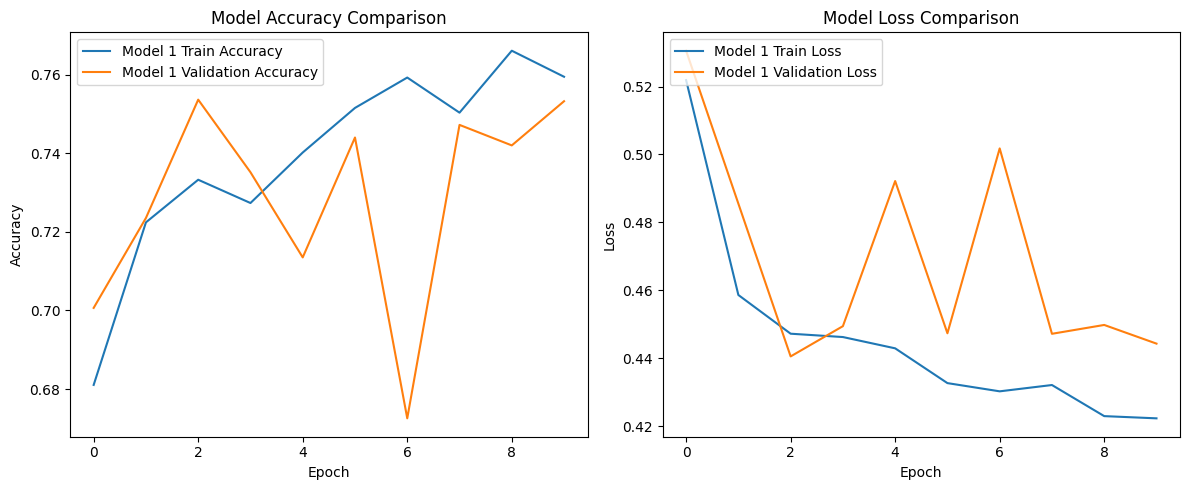

In [ ]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_model2.history['accuracy'], label='Model 1 Train Accuracy')
plt.plot(history_model2.history['val_accuracy'], label='Model 1 Validation Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_model2.history['loss'], label='Model 1 Train Loss')
plt.plot(history_model2.history['val_loss'], label='Model 1 Validation Loss')
plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Adjust layout and display
plt.tight_layout()
plt.show()


Testing the model

In [ ]:
X_test_lstm = lstm_tokenizer.texts_to_sequences(X_test)
X_test_lstm = pad_sequences(X_test_lstm, padding='post', maxlen=300)


test_loss, test_accuracy = lstm_model.evaluate(X_test_lstm, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7523 - loss: 0.4344
Test Loss: 0.4322827160358429
Test Accuracy: 0.7508028149604797


Confusion matrix

98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Classification Report:
              precision    recall  f1-score   support

    Negative       0.60      0.73      0.66      1038
    Positive       0.66      0.52      0.58      1038
     Neutral       1.00      1.00      1.00      1038

    accuracy                           0.75      3114
   macro avg       0.75      0.75      0.75      3114
weighted avg       0.75      0.75      0.75      3114



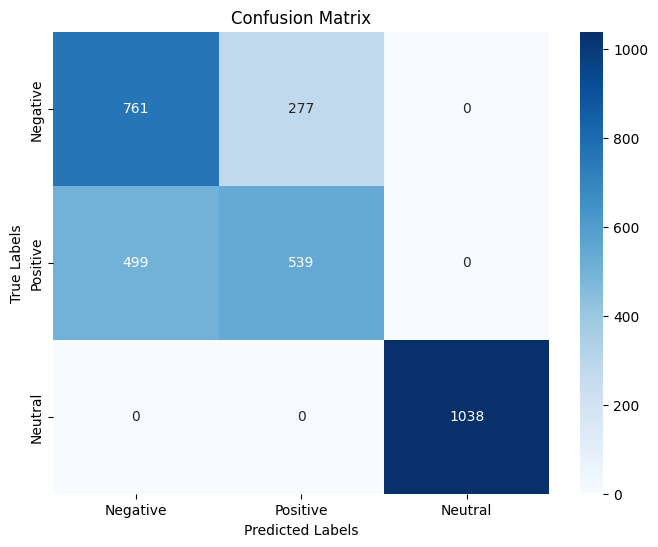

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict classes for the test set
y_pred_probs = lstm_model.predict(X_test_lstm)  # Get prediction probabilities
y_pred = np.argmax(y_pred_probs, axis=1)       # Convert probabilities to class indices

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive', 'Neutral'])
print("Classification Report:")
print(report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive', 'Neutral'], yticklabels=['Negative', 'Positive', 'Neutral'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Prediction

In [ ]:
def predict_text_lstm(lstm_model, lstm_tokenizer, text, class_labels, maxlen=300):
    # Tokenize and pad the input text
    text_sequence = lstm_tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(text_sequence, maxlen=maxlen, padding='post')

    # Make prediction
    probabilities = lstm_model.predict(text_padded)
    predicted_class = np.argmax(probabilities, axis=1)[0]

    # Map predicted class to label
    predicted_label = class_labels[predicted_class]

    return predicted_label


In [ ]:
# Define the class labels (same as during training)
class_labels = ['Negative', 'Positive', 'Neutral']

# Example texts
lyrics1 = "This is the worst day of my life."
lyrics2 = "It is just an average day, nothing special."

# Predict using the LSTM model

prediction1 = predict_text_lstm(model2, lstm_tokenizer, lyrics1, class_labels)
prediction2 = predict_text_lstm(model2, lstm_tokenizer, lyrics2, class_labels)

# Print predictions
print(f"Prediction for Negative Text: {prediction1}")
print(f"Prediction for Neutral Text: {prediction2}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for Negative Text: Negative
Prediction for Neutral Text: Negative


# BERT

In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizerFast, TFBertForSequenceClassification, create_optimizer
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# 1. Initialize the Tokenizer
model_id = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_id)

# 2. Tokenize the Dataset
def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=512)

train_encodings = tokenize_function(X_train.tolist())
val_encodings = tokenize_function(X_val.tolist())
test_encodings = tokenize_function(X_test.tolist())

# 3. Convert Tokenized Data to a Pandas DataFrame (for verification)
train_df = pd.DataFrame({
    'text': X_train[:5],
    'label': y_train[:5],
    'input_ids': train_encodings['input_ids'][:5],
    'token_type_ids': train_encodings['token_type_ids'][:5],
    'attention_mask': train_encodings['attention_mask'][:5],
})
print(train_df)

# 4. Create TensorFlow Dataset
def create_tf_dataset(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices(({
        "input_ids": tf.constant(encodings['input_ids']),
        "token_type_ids": tf.constant(encodings['token_type_ids']),
        "attention_mask": tf.constant(encodings['attention_mask']),
    }, tf.constant(labels)))
    return dataset

BATCH_SIZE = 8
tf_train_dataset = create_tf_dataset(train_encodings, y_train.tolist()).shuffle(len(y_train)).batch(BATCH_SIZE)
tf_val_dataset = create_tf_dataset(val_encodings, y_val.tolist()).batch(BATCH_SIZE)
tf_test_dataset = create_tf_dataset(test_encodings, y_test.tolist()).batch(BATCH_SIZE)

# 5. Verify TensorFlow Dataset
for batch in tf_train_dataset.take(1):
    print(batch)


                                                    text  label  \
15290  told my idea of seduction be a bit passe i hea...      2   
5396   plastic people with their plastic life plastic...      1   
12896  from the land of them straight razor face bear...      2   
3254   out on the road late at night the highway be s...      0   
11439  there be once a farmer walk down the road whis...      2   

                                               input_ids  \
15290  [101, 2409, 2026, 2801, 1997, 26962, 2022, 103...   
5396   [101, 6081, 2111, 2007, 2037, 6081, 2166, 6081...   
12896  [101, 2013, 1996, 2455, 1997, 2068, 3442, 1508...   
3254   [101, 2041, 2006, 1996, 2346, 2397, 2012, 2305...   
11439  [101, 2045, 2022, 2320, 1037, 7500, 3328, 2091...   

                                          token_type_ids  \
15290  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
5396   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
12896  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

Compile and train the model

In [ ]:
# 6. Initialize BERT Model with Dropout Regularization
model = TFBertForSequenceClassification.from_pretrained(model_id, num_labels=3)
model.config.hidden_dropout_prob = 0.7
model.config.attention_probs_dropout_prob = 0.6
model.summary()

# 7. Compile the Model
num_epochs = 3
batches_per_epoch = len(y_train) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(
    init_lr=1e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=['accuracy'],
)

# 8. Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

# 9. Train the Model
history = model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=num_epochs,
    callbacks=[early_stopping]
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109484547 (417.65 MB)
Trainable params: 109484547 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3
1246/1246 [==============================] - 1319s 1s/step - loss: 0.5155 - accuracy: 0.7245 - val_loss: 0.4374 - val_accuracy: 0.7588
Epoch 2/3
1246/1246 [==============================] - 1278s 1s/step - loss: 0.4127 - accuracy: 0.7843 -

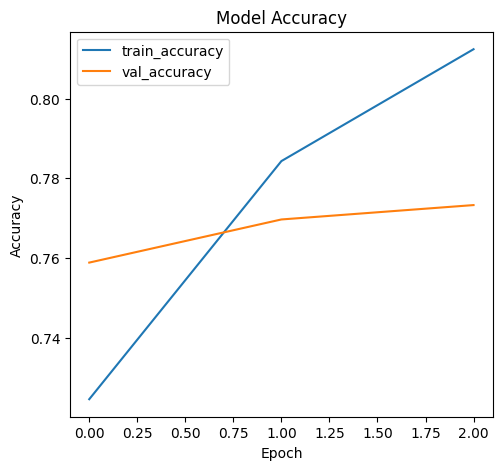

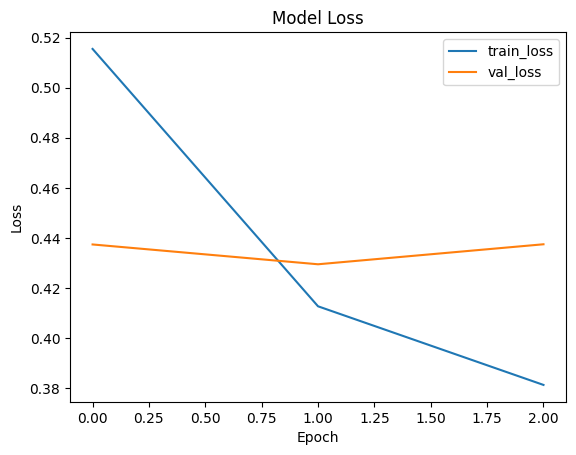

In [ ]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Testing

In [ ]:
# 11. Evaluate on Test Data
test_results = model.evaluate(tf_test_dataset)
print(f"Test Loss: {test_results[0]}")
print(f"Test Accuracy: {test_results[1]}")

390/390 [==============================] - 131s 335ms/step - loss: 0.4152 - accuracy: 0.7736
Test Loss: 0.41519448161125183
Test Accuracy: 0.773603081703186


Confusion Matrix

390/390 [==============================] - 136s 333ms/step


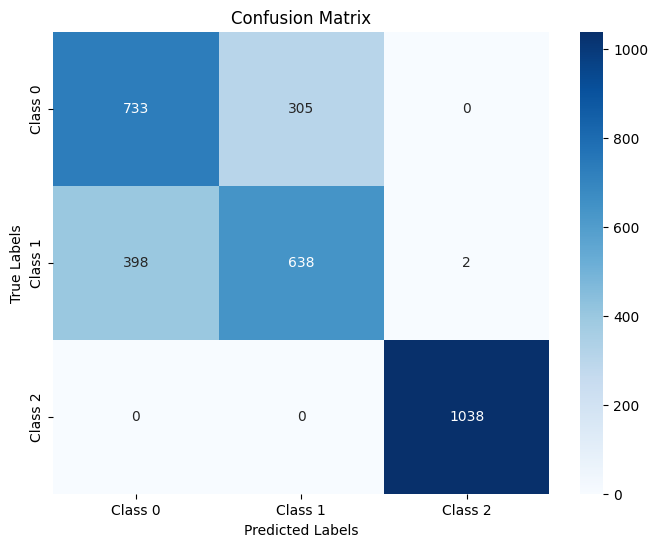

              precision    recall  f1-score   support

     Class 0       0.65      0.71      0.68      1038
     Class 1       0.68      0.61      0.64      1038
     Class 2       1.00      1.00      1.00      1038

    accuracy                           0.77      3114
   macro avg       0.77      0.77      0.77      3114
weighted avg       0.77      0.77      0.77      3114



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test dataset
y_pred_probs = model.predict(tf_test_dataset)
y_pred = np.argmax(y_pred_probs.logits, axis=1)
y_true = np.array(y_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2'])
print(report)


Prediction

In [ ]:
def predict_lyrics_class(model, tokenizer, lyrics, class_labels):
    inputs = tokenizer(
        lyrics,
        return_tensors="tf",
        truncation=True,
        padding="max_length",
        max_length=512
    )

    outputs = model(inputs)
    logits = outputs.logits
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]

    predicted_label = class_labels[predicted_class]

    return predicted_label


In [ ]:
class_labels = ['Negative', 'Positive', 'Neutral']

# Example lyrics
positive_lyrics = "I'm walking on sunshine, oh oh!"
negative_lyrics = "i feel like drowing in the sea "
neutral_lyrics = "It's an average day, nothing special."

predicted_label = predict_lyrics_class(model, tokenizer, positive_lyrics, class_labels)
print(f"Predicted class for positive lyrics: {predicted_label}")

predicted_label = predict_lyrics_class(model, tokenizer, negative_lyrics, class_labels)
print(f"Predicted class for negative lyrics: {predicted_label}")

predicted_label = predict_lyrics_class(model, tokenizer, neutral_lyrics, class_labels)
print(f"Predicted class for neutral lyrics: {predicted_label}")


Predicted class for positive lyrics: Positive
Predicted class for negative lyrics: Negative
Predicted class for neutral lyrics: Neutral
